# üìà <span style="color:#086591; text-decoration: underline;">Partie Mod√©lisation</span>


Maintenant nous sommes arriv√©s √† la partie de mod√©lisation.
Nous cherchons √† expliquer les retards gr√¢ce √† des variables explicatives. Dans un premier temps, nous allons mod√©liser le jeu de donn√©es existant en adoptant la r√©gression logistique suivie dela m√©thode Random Forest . Puis, nous nous int√©resserons √† la comparaison des performances entre ces deux m√©thodes.

#### Le choix de m√©thode ###
Nous avons choisi la r√©gression logistique et Random forest car nous sommes face √† un probl√®me  de classification binaire o√π la variable cible "Retard" prend deux valeurs : 0 (pas de retard) et 1 (retard).

### üß† <span style="text-decoration: underline;">**R√©gression Logistique :**

un probl√®me de classification binaire de mani√®re lin√©aire, c‚Äôest-√†-dire mod√©liser y ¬£ {0,1}  √† l‚Äôaide d‚Äôune combinaison lin√©aire de variables.


In [493]:
#biblioth√®ques
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_curve, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, chi2
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [494]:
data = pd.read_csv("data.csv")
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50697 entries, 0 to 50696
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      50697 non-null  object 
 1   Destination Airport                       50697 non-null  object 
 2   Scheduled departure time                  50697 non-null  object 
 3   Actual departure time                     50697 non-null  object 
 4   Wheels-off time                           50697 non-null  object 
 5   Taxi-Out time (Minutes)                   50697 non-null  float64
 6   Delay Carrier (Minutes)                   50697 non-null  float64
 7   Delay Weather (Minutes)                   50697 non-null  float64
 8   Delay National Aviation System (Minutes)  50697 non-null  float64
 9   Delay Security (Minutes)                  50697 non-null  float64
 10  Delay Late Aircraft Arrival (Minut

Je vais laisser que des variables qui peuvent avoir un effet c'est-√†-dire je vais supprimer les variables ind√©sirables , comme time date ... etc.

In [495]:
df = data.drop('time', axis=1)
colu= ["Season","Period_Day","Weekday_Flight","Destination Airport","Date","Scheduled departure time","Actual departure time","Wheels-off time"]
df = df.drop(columns=colu)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50697 entries, 0 to 50696
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Taxi-Out time (Minutes)                   50697 non-null  float64
 1   Delay Carrier (Minutes)                   50697 non-null  float64
 2   Delay Weather (Minutes)                   50697 non-null  float64
 3   Delay National Aviation System (Minutes)  50697 non-null  float64
 4   Delay Security (Minutes)                  50697 non-null  float64
 5   Delay Late Aircraft Arrival (Minutes)     50697 non-null  float64
 6   Retard                                    50697 non-null  int64  
 7   Weekday_Flight_encoded                    50697 non-null  int64  
 8   Season_encoded                            50697 non-null  int64  
 9   Period_Day_encoded                        50697 non-null  int64  
 10  Destination_encoded               

Le pre-processing est un Standard Scaler permettant de standardiser les donn√©es.

L'approche Train-Test Split consiste √† d√©composer de mani√®re al√©atoire notre donn√©es. Une partie servira √† l‚Äôentra√Ænement du mod√®le (training) et on r√©serve 70% √† 80% des donn√©es du dataset pour l‚Äôentra√Ænement, l‚Äôautre partie permettra de le tester pour la validation.

In [496]:
# Normalisation des colonnes num√©riques
scaler = MinMaxScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Division al√©atoire en ensembles d'apprentissage et de test
seed = 131
train_set, test_set = train_test_split(df, test_size=0.2, random_state=seed)


In [497]:
train_set['Retard'].value_counts(normalize=True)*100

Retard
0.0    68.138669
1.0    31.861331
Name: proportion, dtype: float64

# **Le probl√®me de d√©s√©quilibre de classes  Class  | Imbalance Problem**

pour r√©soudre ce type des probl√®mes on utilise la m√©thode du r√©√©chantillonnage des donn√©es .

le r√©√©chantillonnage des donn√©es : 

- **Random Under Sampling  RUS , sous √©chantillonement de la classe majoritaire:**

consiste √† tirer au hasard des observations de cas de non-defaut pour correspondre au nombre d‚Äôobservations de cas de defaut de paiement . 

Le RUS vise √† r√©duire le d√©s√©quilibre en diminuant la taille de la classe majoritaire. Cela se fait en supprimant al√©atoirement des observations de la classe majoritaire jusqu'√† ce que le nombre d'observations dans cette classe corresponde approximativement √† celui de la classe minoritaire

une perte massive d‚Äôinformations potentiellement importantes

- **Random Over Sampling  ROS , sur √©chantillonement de la classe minoritaire:**

consiste √† effectuer des tirages al√©atoires d‚Äôobservations de cas de d√©faut et dupliquer ces observations afin de correspondre au nbre de cas de non-d√©faut.

vise √† augmenter la taille de la classe minoritaire en dupliquant des observations de cette classe ou en g√©n√©rant de nouvelles observations synth√©tiques

on peut avoir un surapprentissage (overfitting)

- **Synthetic Minority Oversampling Technique ou SMOTE**

SMOTE g√©n√®re de nouvelles observations synth√©tiques en se basant sur les caract√©ristiques des observations existantes.

1. **S√©lection d'une observation :**
SMOTE commence par choisir al√©atoirement une observation de la classe minoritaire.
2. **Trouver les voisins les plus proches :**
SMOTE identifie les k voisins les plus proches de cette observation dans la classe minoritaire (k √©tant g√©n√©ralement un param√®tre d√©fini par l'utilisateur). Ces voisins sont trouv√©s dans l'espace des caract√©ristiques, souvent √† l'aide d'une m√©trique de distance comme la distance euclidienne.

In [498]:
# Sous-√©chantillonnage
rus = RandomUnderSampler(random_state=seed)
train_undersampled, train_undersampled_labels = rus.fit_resample(train_set.drop('Retard', axis=1),
                                                                 train_set['Retard'])
print(type(train_undersampled))
print(train_undersampled.describe())

# Sur-√©chantillonnage
ros = RandomOverSampler(random_state=seed)
train_oversampled, train_oversampled_labels = ros.fit_resample(train_set.drop('Retard', axis=1),
                                                               train_set['Retard'])


<class 'pandas.core.frame.DataFrame'>
       Taxi-Out time (Minutes)  Delay Carrier (Minutes)  \
count             25844.000000             25844.000000   
mean                  0.137334                 0.004738   
std                   0.072377                 0.025319   
min                   0.000000                 0.000000   
25%                   0.096045                 0.000000   
50%                   0.118644                 0.000000   
75%                   0.152542                 0.000000   
max                   0.926554                 1.000000   

       Delay Weather (Minutes)  Delay National Aviation System (Minutes)  \
count             25844.000000                              25844.000000   
mean                  0.000852                                  0.003953   
std                   0.012844                                  0.015173   
min                   0.000000                                  0.000000   
25%                   0.000000                    

In [499]:
# Taille avant sur-√©chantillonnage
print(train_set['Retard'].value_counts())

# Taille apr√®s sur-√©chantillonnage
oversampled_df = pd.DataFrame(train_oversampled, columns=train_set.drop('Retard', axis=1).columns)
oversampled_df['Retard'] = train_oversampled_labels
print(oversampled_df['Retard'].value_counts())

# Taille apr√®s sous-√©chantillonnage
train_undersampled_df = pd.DataFrame(train_undersampled, columns=train_set.drop('Retard', axis=1).columns)
train_undersampled_df['Retard'] = train_undersampled_labels
print(train_undersampled_df['Retard'].value_counts())



Retard
0.0    27635
1.0    12922
Name: count, dtype: int64
Retard
1.0    27635
0.0    27635
Name: count, dtype: int64
Retard
0.0    12922
1.0    12922
Name: count, dtype: int64


# Cr√©ation du mod√®le. 
Nous avons choisi le sur-√©chantillonnage car  on voit bien  une diff√©rence significative entre les classes 27,635 contre 12,922.
le sur-√©chantillonnage est  pr√©f√©rable dans ce cas , car il permet de conserver la totalit√©  des donn√©es de la classe majoritaire (classe 1).

Nous avons  effectu√© une analyse approfondie des coefficients, de leur significativit√© statistique, ainsi que de la corr√©lation de Pearson entre les variables explicatives et la variable cible "Retard".



In [500]:
# Mod√®le de r√©gression logistique
x_train = train_oversampled
y_train = train_oversampled_labels
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Coefficients du mod√®le
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]
coeff_df = pd.DataFrame({'Variable': x_train.columns, 'Coefficient': coefficients})
coeff_df.loc[len(coeff_df)] = ['Intercept', intercept]
print(coeff_df)

# Calcul des statistiques
n = len(y_train)
p = x_train.shape[1]
X = np.hstack((np.ones((n, 1)), x_train))
y_pred = clf.predict(x_train)
residus = y_train - y_pred
sigma_hat = np.sqrt(np.sum(residus ** 2) / (n - p))
var_cov_beta = np.linalg.inv(X.T @ X) * sigma_hat ** 2
std_err_beta = np.sqrt(np.diag(var_cov_beta))

# Variables significatives
alpha = 0.1
z_score = clf.coef_ / std_err_beta[1:]
p_values = 2 * (1 - chi2.cdf(z_score ** 2, 1))
significant_vars = x_train.columns[np.array(p_values).reshape(-1) < alpha]
print("Variables significatives :", significant_vars)

# Mod√®le r√©duit aux variables significatives
significant_coefs = clf.coef_[0][np.isin(x_train.columns, significant_vars)]
significant_model = pd.DataFrame({'Variable': significant_vars, 'Coefficient': significant_coefs})
print("Mod√®le significatif :\n", significant_model)

# Corr√©lation de Pearson
pearson_correlation = []
pearson_p_value = []
for var in x_train.columns:
    correlation, p_value = pearsonr(x_train[var], y_train)
    pearson_correlation.append(correlation)
    pearson_p_value.append(p_value)

alpha = 0.05
significant_vars = [var for var, p_value in zip(x_train.columns, pearson_p_value) if p_value < alpha]
print("Variables significatives (avec une erreur alpha de 5%) : \n", significant_vars)


                                    Variable  Coefficient
0                    Taxi-Out time (Minutes)     2.765947
1                    Delay Carrier (Minutes)    25.028333
2                    Delay Weather (Minutes)     5.823790
3   Delay National Aviation System (Minutes)    10.544062
4                   Delay Security (Minutes)     3.915299
5      Delay Late Aircraft Arrival (Minutes)    24.065809
6                     Weekday_Flight_encoded    -0.107880
7                             Season_encoded    -0.206194
8                         Period_Day_encoded    -0.090898
9                        Destination_encoded    -0.278803
10                       temperature_2m (¬∞C)     0.522650
11                  relative_humidity_2m (%)    -0.663656
12                        precipitation (mm)    -0.419743
13                            snow_depth (m)     0.205710
14                   weather_code (wmo code)     0.329572
15                    surface_pressure (hPa)     0.287332
16           

### Analyse de r√©sultats ###

√Ä un seuil de significativit√© (Œ±=0.1), toutes les variables de notre mod√®le sont  statistiquement significatives car leurs p-values sont inf√©rieures √† 0.1. Cela signifie que leurs effets sur la variable cible "Retard" sont suffisamment importants et on est oblig√© de les inclure .

Les coefficients indiquent l'effet marginal de chaque variable  explicative sur la probabilit√© de survenue d'un retard (variable cible ) :

- **Effet positif** : l'augmentation d'une unit√© de cette variable augmente la probabilit√© de retard.  
- **Effet n√©gatif** : l'augmentation d'une unit√© de cette variable r√©duit la probabilit√© de retard.


Nous allons d√©finir la m√©trique  pour √©valuer la performance des mod√®les

![Matrice de confusion](images/Untitled.png)

True Positive (TP) :
L‚Äôavion est effectivement en retard (classe 1), et le mod√®le pr√©dit qu‚Äôil est en retard (classe 1).

True Negative (TN) :
L‚Äôavion n‚Äôest pas en retard (classe 0), et le mod√®le pr√©dit qu‚Äôil n‚Äôest pas en retard (classe 0).

False Negative (FN) :
L‚Äôavion est en retard (classe 1), mais le mod√®le pr√©dit qu‚Äôil n‚Äôest pas en retard (classe 0).

False Positive (FP) :
L‚Äôavion n‚Äôest pas en retard (classe 0), mais le mod√®le pr√©dit qu‚Äôil est en retard (classe 1).

**Accuracy | Sensitivity | Specificity**

**Accuracy = $TN +TP/(TN +FN+FP +TP)$**

c‚Äôest la pr√©cision de la classification , le pourcentage d‚Äôinstances correctement classif√©es ie le pourcentage des TP et TN

**Sensitivity = $TP/(FN +TP)$** 

C'est le pourcentage des instances positives r√©elles  qui sont correctement classif√©es comme positives par le mod√®le.
le taux de classes positives

**Specificity = $TN/(FP + TN)$**

C'est le pourcentage des instances n√©gatives r√©elles qui sont correctement classif√©es comme n√©gatives par le mod√®le.
le taux de classes negatives

In [501]:
def model_evaluation(model, seuil):
    predictions = model.predict_proba(test_set.drop('Retard', axis=1))[:, 1]
    predicted_status = (predictions > seuil).astype(int)
    
    conf_mat = pd.crosstab(test_set['Retard'], predicted_status, dropna=False)
    conf_mat = conf_mat.reindex(index=[0, 1], columns=[0, 1], fill_value=0)

    # V√©rifiez si la matrice est correcte
    if conf_mat.shape[0] < 2 or conf_mat.shape[1] < 2:
        raise ValueError("Matrice de confusion incompl√®te ou incorrecte.")

    TP = conf_mat.iloc[1, 1]
    TN = conf_mat.iloc[0, 0]
    FP = conf_mat.iloc[0, 1]
    FN = conf_mat.iloc[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return {
        'Classification Score': accuracy,
        'Model Sensitivity': sensitivity,
        'Model Specificity': specificity
    }


Seuil optimal pour maximiser Accuracy:
seuil            0.580000
Accuracy         0.760256
Sensitivity      0.364096
Specificity      0.939937
1-Specificity    0.060063
Name: 57, dtype: float64

Seuil optimal pour √©quilibrer Sensibilit√© et Sp√©cificit√©:
seuil            0.460000
Accuracy         0.654241
Sensitivity      0.661504
Specificity      0.650946
1-Specificity    0.349054
Name: 45, dtype: float64

Seuil optimal bas√© sur la distance au point parfait (ROC):
seuil                  0.470000
Accuracy               0.672781
Sensitivity            0.634640
Specificity            0.690080
1-Specificity          0.309920
Distance_to_Perfect    0.479102
Name: 46, dtype: float64


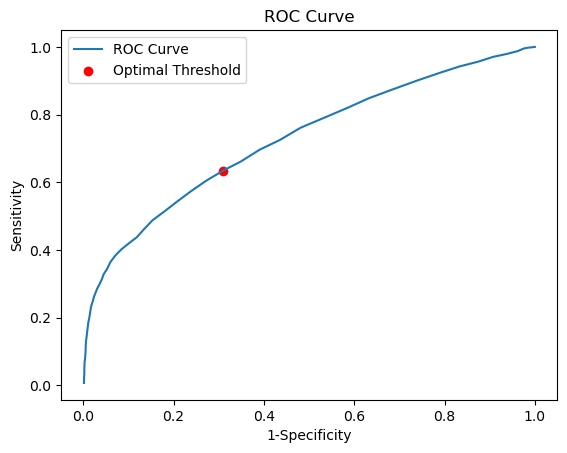

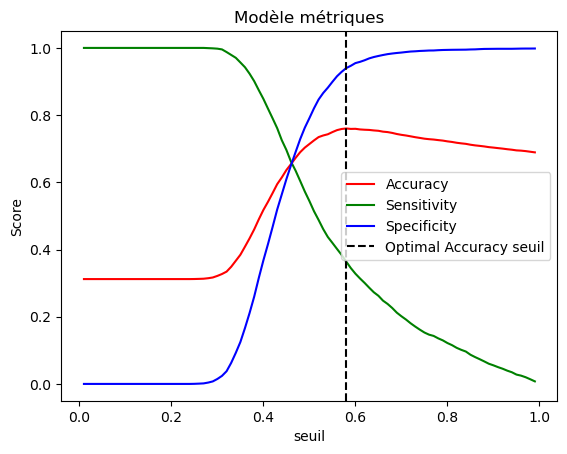

les seuils sont  :  [0.5800000000000001, 0.46, 0.47000000000000003]


In [502]:
def print_results(model):
    seuils = np.arange(0.01, 1.0, 0.01)
    acc_model, sens_model, spec_model, one_minus_spec_model = [], [], [], []
    for i in seuils:
        r = model_evaluation(model, i)
        acc_model.append(r['Classification Score'])
        sens_model.append(r['Model Sensitivity'])
        spec_model.append(r['Model Specificity'])
        one_minus_spec_model.append(1 - r['Model Specificity'])
    
    # Cr√©er un DataFrame pour les r√©sultats
    metriques = pd.DataFrame({
        'seuil': seuils,
        'Accuracy': acc_model,
        'Sensitivity': sens_model,
        'Specificity': spec_model,
        '1-Specificity': one_minus_spec_model
    })
    
    # Trouver le seuil optimal selon diff√©rents crit√®res
    optimal_acc = metriques.loc[metriques['Accuracy'].idxmax()]
    optimal_sens_spec = metriques.iloc[(metriques['Sensitivity'] - metriques['Specificity']).abs().idxmin()]
    metriques['Distance_to_Perfect'] = np.sqrt(metriques['1-Specificity']**2 + (1 - metriques['Sensitivity'])**2)
    optimal_roc = metriques.loc[metriques['Distance_to_Perfect'].idxmin()]

    print("Seuil optimal pour maximiser Accuracy:")
    print(optimal_acc)
    print("\nSeuil optimal pour √©quilibrer Sensibilit√© et Sp√©cificit√©:")
    print(optimal_sens_spec)
    print("\nSeuil optimal bas√© sur la distance au point parfait (ROC):")
    print(optimal_roc)
    
    # Courbe ROC
    plt.figure()
    plt.plot(metriques['1-Specificity'], metriques['Sensitivity'], label='ROC Curve')
    plt.scatter(optimal_roc['1-Specificity'], optimal_roc['Sensitivity'], color='red', label='Optimal Threshold')
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Courbes des m√©triques
    plt.figure()
    plt.plot(metriques['seuil'], metriques['Accuracy'], label='Accuracy', color='red')
    plt.plot(metriques['seuil'], metriques['Sensitivity'], label='Sensitivity', color='green')
    plt.plot(metriques['seuil'], metriques['Specificity'], label='Specificity', color='blue')
    plt.axvline(optimal_acc['seuil'], color='black', linestyle='--', label='Optimal Accuracy seuil')
    plt.xlabel('seuil')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Mod√®le m√©triques')
    plt.show()
    
    optimale_seuil = [
        optimal_acc['seuil'],   # Seuil pour Accuracy
        optimal_sens_spec['seuil'],  # Seuil pour √©quilibrer Sensibilit√© et Sp√©cificit√©
        optimal_roc['seuil']    # Seuil bas√© sur la distance au point parfait (ROC)
    ]
    
    print("les seuils sont  : " , optimale_seuil)
    

    
    
print_results(clf)


### üß† <span style="text-decoration: underline;">**Random Forest :**


Le Random Forest ou la for√™t al√©atoire est un ensemble d'arbres de d√©cision utilis√©s pour pr√©dire une probabilit√© (la probabilit√© d'avoir un retard).Chaque arbre de d√©cision dans la for√™t fait une pr√©diction de probabalit√© , et la for√™t al√©atoire combine ces pr√©dictions pour obtenir un r√©sultat final un peu plus robuste et pr√©cis.

Un arbre de d√©cision (binaire) est une structure descendante qui a des n≈ìuds et des branches. √Ä chaque n≈ìud, une condition  bien definis va nous permettre de nous diriger dans l'arbre, jusqu'√† arriver √† la fin de l'arbre.

#### Division de la base de donn√©e ####

Nous allons proc√©der de la m√™me mani√®re que pour la r√©gression logistique, en √©quilibrant les deux classes 0 et 1.

In [503]:
X= df.drop(columns=['Retard'])
y = df['Retard']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Sous-√©chantillonnage
rus = RandomUnderSampler(random_state=seed)
train_undersampled, train_undersampled_labels = rus.fit_resample(X_train,y_train)
train_undersampled_test, train_undersampled_labels_test = rus.fit_resample(X_test,y_test)


# Sur-√©chantillonnage
ros = RandomOverSampler(random_state=seed)
train_oversampled, train_oversampled_labels = ros.fit_resample(X_train,
                                                                 y_train)
train_oversampled_test, train_oversampled_labels_test = ros.fit_resample(X_test,y_test)



#### Cr√©ation du mod√®le ####

Nous allons fixer  random_state=42 et le nombre de arbres de d√©cision =100. 

In [504]:
Rand_Fore = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
Rand_Fore.fit(train_oversampled, train_oversampled_labels)
y_pred = Rand_Fore.predict(train_oversampled_test)
print("Accuracy:", accuracy_score(train_oversampled_labels_test, y_pred))


KeyboardInterrupt: 

Accuracy: 0.7162070304913576 :Cela signifie que 72 % des pr√©dictions globales √©taient correctes.

Rapport de Classification :
               precision    recall  f1-score   support

         0.0       0.65      0.93      0.77     10298
         1.0       0.88      0.50      0.64     10298

    accuracy                           0.72     20596
   macro avg       0.77      0.72      0.70     20596
weighted avg       0.77      0.72      0.70     20596



Text(50.722222222222214, 0.5, 'valeurs r√©elles')

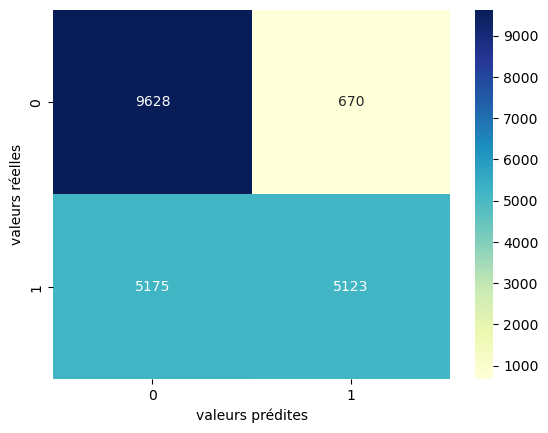

In [490]:
#Les m√©triques :Pr√©cision  Rappel  F1-Score 
 
print("Rapport de Classification :\n", classification_report(train_oversampled_labels_test, y_pred))

#matrice de confusion 
sns.heatmap(confusion_matrix(train_oversampled_labels_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')

plt.xlabel('valeurs pr√©dites')
plt.ylabel('valeurs r√©elles')


## Analyse de r√©sultats :

### Classe 0 (Pas de retard) :
√† partir de ces r√©sultats on voit bien une **precision** de 65% cela veut dire que parmi toutes les pr√©dictions faites par ton mod√®le pour la classe 0, 65 % √©taient correctes.En suite on a un **recall** de 93%  c'est-√†-dire 93 % des instances r√©elles de la classe 0 ont  correctement identifi√©es ce qui montre que notre mod√®le d√©tecte bien les instances de la classe 0, avec peu de faux n√©gatifs.
Pour le **F1-Score** , une valeur de 77% indique une performance √©quilibr√©e pour cette classe, gr√¢ce √† un rappel √©lev√©. Et finalement le **support** est √©gal √† 10,298 qui est exactement la moiti√© des donn√©es.

---
### Classe 1(Retard):
De meme on a une **precision** de 88% donc parmi toutes les pr√©dictions pour la classe 1, 88 % √©taient correctes.Cela signifie que seulement 12 % sont des faux positifs.En outre , on a un **recall**  de 50% donc, seulement 50 % des instances r√©ellement de la classe 1 ont √©t√© correctement identifi√©es c'est-√†-dire que le mod√®le a du mal √† capturer toutes les instances de cette classe.
Pour le **F1-Score** , un F1-score mod√©r√©(64%) refl√®te la tension entre la pr√©cision √©lev√©e et le rappel faible .Enfin un **support** de 10,298 donc La classe 1 repr√©sente √©galement la moiti√© des donn√©es.


In [ ]:
feature_importances = Rand_Fore.feature_importances_
features = df.drop(columns=['Retard']).columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)


                                     Feature  Importance
1                    Delay Carrier (Minutes)    0.144293
0                    Taxi-Out time (Minutes)    0.088940
10                       temperature_2m (¬∞C)    0.072756
15                    surface_pressure (hPa)    0.072458
19                     wind_speed_10m (km/h)    0.071457
20                    wind_direction_10m (¬∞)    0.070328
9                        Destination_encoded    0.067642
18             vapour_pressure_deficit (kPa)    0.064983
5      Delay Late Aircraft Arrival (Minutes)    0.061978
11                  relative_humidity_2m (%)    0.059197
3   Delay National Aviation System (Minutes)    0.037928
16                           cloud_cover (%)    0.036785
6                     Weekday_Flight_encoded    0.033779
17                       cloud_cover_low (%)    0.030226
8                         Period_Day_encoded    0.019578
14                   weather_code (wmo code)    0.018128
7                            

#### Analyse de r√©sultats :

Nous avons fait une analyse de l'importance des caract√©ristiques du mod√®le. on fait l'extraction des importances des caract√©ristiques, on a pu identifier quelles variables jouent un r√¥le crucial dans les pr√©dictions de notre mod√®le. 

Le processus consiste √† mesurer la contribution de chaque variable ou caract√©ristique √† la r√©duction de l'impuret√© lors de la construction des arbres. Par la suite, ces valeurs  peuvent √™tre tri√©es pour d√©terminer les variables qui doivent √™tre privil√©gi√©es dans des analyses futures(par exemple).

### <span style="text-decoration: underline;">GridSearchCV
On va appliquer la m√©thode de recherche par grille pour trouver les meilleurs hyperparam√®tres.

In [ ]:
param_grid = {
    'n_estimators': [100,300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=Rand_Fore, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(train_oversampled, train_oversampled_labels)

modele_meilleur = grid_search.best_estimator_


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s


KeyboardInterrupt: 

Seuil optimal pour maximiser Accuracy:
seuil            0.620000
Accuracy         0.939349
Sensitivity      0.820164
Specificity      0.993406
1-Specificity    0.006594
Name: 61, dtype: float64

Seuil optimal pour √©quilibrer Sensibilit√© et Sp√©cificit√©:
seuil            0.300000
Accuracy         0.909172
Sensitivity      0.908028
Specificity      0.909690
1-Specificity    0.090310
Name: 29, dtype: float64

Seuil optimal bas√© sur la distance au point parfait (ROC):
seuil                  0.350000
Accuracy               0.924951
Sensitivity            0.889381
Specificity            0.941084
1-Specificity          0.058916
Distance_to_Perfect    0.125331
Name: 34, dtype: float64


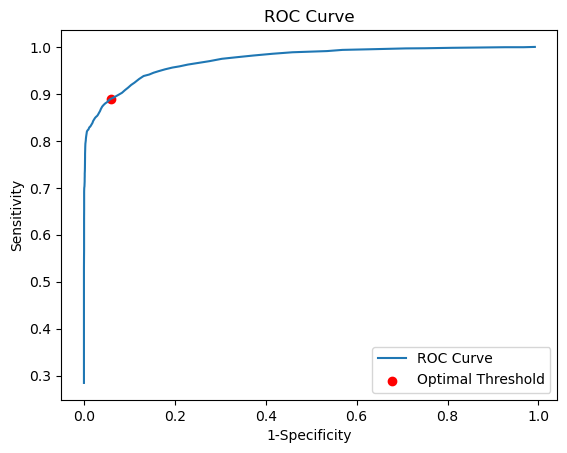

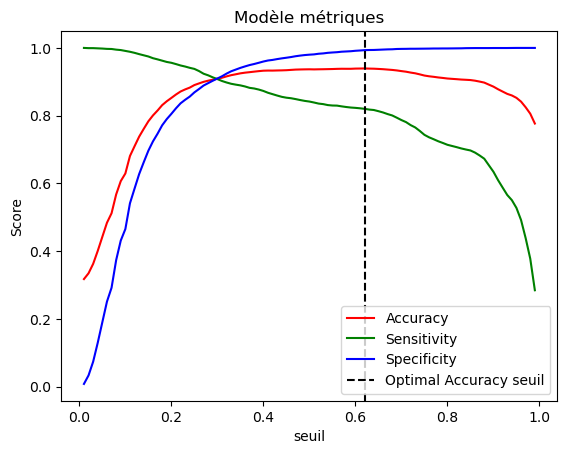

les seuils sont  :  [0.62, 0.3, 0.35000000000000003]


In [394]:
print_results(modele_meilleur)

# Comparaison des deux m√©thodes :

## R√©sum√©
### Random Forest

#### Seuil optimal pour maximiser Accuracy

| Seuil | Accuracy | Sensitivity | Specificity | 1-Specificity |
|-------|----------|-------------|-------------|---------------|
| 0.620 | 0.939349 | 0.820164    | 0.993406    | 0.006594      |

---

### Seuil optimal pour √©quilibrer Sensibilit√© et Sp√©cificit√©

| Seuil | Accuracy | Sensitivity | Specificity | 1-Specificity |
|-------|----------|-------------|-------------|---------------|
| 0.300 | 0.909172 | 0.908028    | 0.909690    | 0.090310      |

---

#### Seuil optimal bas√© sur la distance au point parfait (ROC)

| Seuil | Accuracy | Sensitivity | Specificity | 1-Specificity | Distance_to_Perfect |
|-------|----------|-------------|-------------|---------------|---------------------|
| 0.350 | 0.924951 | 0.889381    | 0.941084    | 0.058916      | 0.125331            |

---

### R√©gression Logistique

#### Seuil optimal pour maximiser Accuracy

| Seuil | Accuracy | Sensitivity | Specificity | 1-Specificity |
|-------|----------|-------------|-------------|---------------|
| 0.580 | 0.760256 | 0.364096    | 0.939937    | 0.060063      |

---

#### Seuil optimal pour √©quilibrer Sensibilit√© et Sp√©cificit√©

| Seuil | Accuracy | Sensitivity | Specificity | 1-Specificity |
|-------|----------|-------------|-------------|---------------|
| 0.460 | 0.654241 | 0.661504    | 0.650946    | 0.349054      |

---

#### Seuil optimal bas√© sur la distance au point parfait (ROC)

| Seuil | Accuracy | Sensitivity | Specificity | 1-Specificity | Distance_to_Perfect |
|-------|----------|-------------|-------------|---------------|---------------------|
| 0.470 | 0.672781 | 0.634640    | 0.690080    | 0.309920      | 0.479102            |


 ## Comparaison bas√©e sur les diff√©rentes m√©triques
## 1. Seuil pour maximiser Accuracy

| Mod√®le                | Seuil | Accuracy  | Sensitivity | Specificity | 1-Specificity |
|-----------------------|-------|-----------|-------------|-------------|---------------|
| **Random Forest**     | 0.620 | **0.9393** | **0.8202**  | **0.9934**  | **0.0066**    |
| **R√©gression Logistique** | 0.580 | 0.7603    | 0.3641      | 0.9399      | 0.0601        |

### Observation :
-On voit bien que la m√©thode de **Random Forest** est  sup√©rieur enterme de **accuracy** (+17.9 points) et aussi en terme **sensibilit√©** (82% vs 36.4%) tout en maintenant une sp√©cificit√© √©lev√©e.

---

## 2. Seuil pour √©quilibrer Sensibilit√© et Sp√©cificit√©

| Mod√®le                | Seuil | Accuracy  | Sensitivity | Specificity | 1-Specificity |
|-----------------------|-------|-----------|-------------|-------------|---------------|
| **Random Forest**     | 0.300 | **0.9092** | **0.9080**  | **0.9097**  | 0.0903        |
| **R√©gression Logistique** | 0.460 | 0.6542    | 0.6615      | 0.6509      | 0.3491        |

### Observation :
On remarque que  **Random Forest** est  meilleur au niveau de l'**accuracy** ,avec une valeur de **0.9092** contre  0.6542   pour la r√©gression logistique.
Un √©quilibre presque parfait entre sensibilit√© (90.8%) et sp√©cificit√© (90.97%) ,alors que ,La r√©gression logistique pr√©sente un d√©s√©quilibre important.

---

## 3. Seuil optimal bas√© sur la distance au point parfait (ROC)

| Mod√®le                | Seuil | Accuracy  | Sensitivity | Specificity | 1-Specificity | Distance_to_Perfect |
|-----------------------|-------|-----------|-------------|-------------|---------------|---------------------|
| **Random Forest**     | 0.350 | **0.9250** | **0.8894**  | **0.9411**  | **0.0589**    | **0.1253**          |
| **R√©gression Logistique** | 0.470 | 0.6728    | 0.6346      | 0.6901      | 0.3099        | 0.4791              |

### Observation :
- **Random Forest** est √† nouveau sup√©rieur , avec une **accuracy** plus √©lev√©e (+25.2 points) et une **sensitivity** et **specificity** aui sont sup√©rieur √† ceux de la r√©gression logistique.
Finalement ,la distance au point parfait (ROC) beaucoup plus faible (0.1253 contre 0.4791), indiquant une meilleure performance globale de la m√©thode Random Forest.

# Conclusion : 

- **Random Forest est clairement le meilleur mod√®le** dans tous les sc√©narios analys√©s :
  - Il atteint une **accuracy** beaucoup plus √©lev√©e.
  - Il offre un excellent √©quilibre entre **sensibilit√©** et **sp√©cificit√©** .
  - Sa performance est robuste quel que soit le seuil choisi et il se rapproche davantage du point id√©al de la courbe ROC.

- **R√©gression Logistique**, bien qu'interpr√©table et rapide, est d√©pass√©e dans ce cas :
  - Sa sensibilit√© est particuli√®rement faible, ce qui peut poser probl√®me dans des cas n√©cessitant une d√©tection √©lev√©e (faux n√©gatifs critiques).
